In [13]:
# https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a
# https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
# https://www.youtube.com/watch?v=fEd1p8-3S7w&ab_channel=JonCavallieMester

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Load data

rating df

In [16]:
df_rating = pd.read_csv('ratings.csv')

In [17]:
df_rating.shape

(100836, 4)

In [18]:
df_rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


movie name df

In [19]:
df_name = pd.read_csv('movies.csv')

In [20]:
df_name.shape

(9742, 3)

In [21]:
df_name.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


join both

In [22]:
df = pd.merge(df_rating, df_name, on='movieId', how='inner')

In [23]:
df = df[['userId','movieId','title','rating']]

In [24]:
df.shape

(100836, 4)

In [25]:
df.head()

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,1,3,Grumpier Old Men (1995),4.0
2,1,6,Heat (1995),4.0
3,1,47,Seven (a.k.a. Se7en) (1995),5.0
4,1,50,"Usual Suspects, The (1995)",5.0


# 2. Check data quality

data type

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   title    100836 non-null  object 
 3   rating   100836 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


unique value

In [27]:
df.shape

(100836, 4)

In [28]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  userId
Unique value:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 2

missing value

In [29]:
df.isnull().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

blank value

In [30]:
(df == '').sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

check movie id

In [31]:
movieid_counts = df.groupby('title').agg(number_movieid=('movieId', pd.Series.nunique)).reset_index()

In [32]:
multiple_movieid = movieid_counts[movieid_counts['number_movieid'] > 1]

In [33]:
multiple_movieid

,title,number_movieid
1934,Confessions of a Dangerous Mind (2002),2
2718,Emma (1996),2
2780,Eros (2004),2
7378,Saturn 3 (1980),2
9269,War of the Worlds (2005),2


In [34]:
max_movieid_df = df.groupby('title')['movieId'].max().reset_index()

In [35]:
df = pd.merge(df, max_movieid_df, on='title', how='inner')

In [36]:
df = df.rename(columns={'movieId_y': 'movieId'})

In [37]:
df = df[['userId','movieId','title','rating']]

In [38]:
df

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,1,3,Grumpier Old Men (1995),4.0
2,1,6,Heat (1995),4.0
3,1,47,Seven (a.k.a. Se7en) (1995),5.0
4,1,50,"Usual Suspects, The (1995)",5.0
...,...,...,...,...
100831,610,166534,Split (2017),4.0
100832,610,168248,John Wick: Chapter Two (2017),5.0
100833,610,168250,Get Out (2017),5.0
100834,610,168252,Logan (2017),5.0


check title

In [39]:
title_counts = df.groupby('movieId').agg(number_title=('title', pd.Series.nunique)).reset_index()

In [40]:
multiple_title = title_counts[title_counts['number_title'] > 1]

In [41]:
multiple_title

,movieId,number_title


unique value (again)

In [42]:
df.shape

(100836, 4)

In [43]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  userId
Unique value:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 2

In [44]:
df

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,1,3,Grumpier Old Men (1995),4.0
2,1,6,Heat (1995),4.0
3,1,47,Seven (a.k.a. Se7en) (1995),5.0
4,1,50,"Usual Suspects, The (1995)",5.0
...,...,...,...,...
100831,610,166534,Split (2017),4.0
100832,610,168248,John Wick: Chapter Two (2017),5.0
100833,610,168250,Get Out (2017),5.0
100834,610,168252,Logan (2017),5.0


# 3. Exploratory data analysis (EDA)

columns name

In [45]:
df.columns

Index(['userId', 'movieId', 'title', 'rating'], dtype='object')

rating max/min/distribution

In [46]:
df['rating'].max()

5.0

In [47]:
df['rating'].min()

0.5

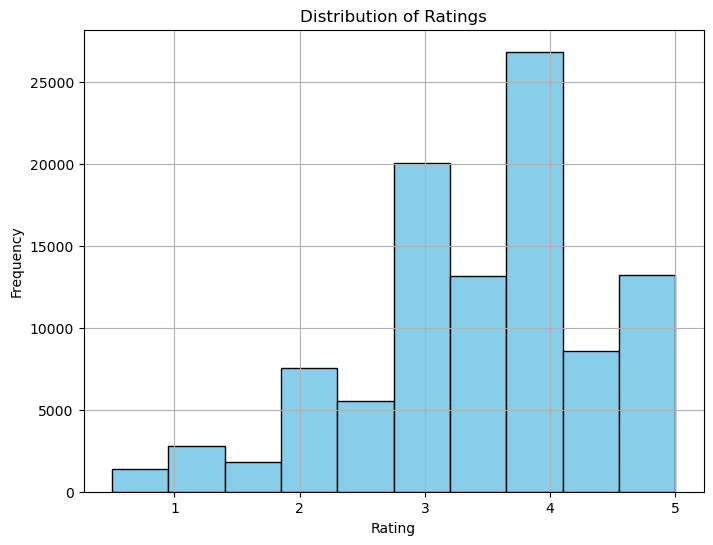

In [48]:
plt.figure(figsize=(8, 6))
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.grid(True)
plt.show()

average rating by title

In [49]:
avg_rating_by_title = df.groupby('title')['rating'].mean()

In [50]:
avg_rating_by_title_sorted = avg_rating_by_title.sort_values(ascending=False)

In [51]:
avg_rating_by_title_sorted

title
Gena the Crocodile (1969)                  5.0
True Stories (1986)                        5.0
Cosmic Scrat-tastrophe (2015)              5.0
Love and Pigeons (1985)                    5.0
Red Sorghum (Hong gao liang) (1987)        5.0
                                          ... 
Don't Look Now (1973)                      0.5
Journey 2: The Mysterious Island (2012)    0.5
Joe Dirt 2: Beautiful Loser (2015)         0.5
Jesus Christ Vampire Hunter (2001)         0.5
Fullmetal Alchemist 2018 (2017)            0.5
Name: rating, Length: 9719, dtype: float64

average rating by userId

In [52]:
avg_rating_by_userId = df.groupby('userId')['rating'].mean()

In [53]:
avg_rating_by_userId_sorted = avg_rating_by_userId.sort_values(ascending=False)

In [54]:
avg_rating_by_userId_sorted

userId
53     5.000000
251    4.869565
515    4.846154
25     4.807692
30     4.735294
         ...   
567    2.245455
153    2.217877
508    2.145833
139    2.144330
442    1.275000
Name: rating, Length: 610, dtype: float64

count userId by title

In [55]:
count_userId_by_title = df.groupby('title')['userId'].nunique()

In [56]:
count_userId_by_title_sorted = count_userId_by_title.sort_values(ascending=False)

In [57]:
count_userId_by_title_sorted

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
                                            ... 
King Solomon's Mines (1950)                    1
King Solomon's Mines (1937)                    1
King Ralph (1991)                              1
King Kong Lives (1986)                         1
À nous la liberté (Freedom for Us) (1931)      1
Name: userId, Length: 9719, dtype: int64

count title by userId

In [58]:
count_title_by_userId = df.groupby('userId')['title'].nunique()

In [59]:
count_title_by_userId_sorted = count_title_by_userId.sort_values(ascending=False)

In [60]:
count_title_by_userId_sorted

userId
414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
442      20
569      20
320      20
576      20
53       20
Name: title, Length: 610, dtype: int64

# 4. Model - user based

pivot

In [61]:
user_item_metrix = df.pivot_table(index='userId', columns='title', values='rating')

In [62]:
user_item_metrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [63]:
user_item_metrix_filled = user_item_metrix.fillna(0)

similarity

In [64]:
user_similarity = cosine_similarity(user_item_metrix_filled)

In [65]:
user_similarity = pd.DataFrame(user_similarity, index=user_item_metrix.index, columns=user_item_metrix.index)

In [66]:
user_similarity

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


# 5. Prediction - user based

setup

In [67]:
picked_userid = 407
k = 10

top similar user

In [68]:
similar_users = user_similarity[picked_userid].sort_values(ascending=False)[:k]

In [69]:
similar_users

userId
407    1.000000
30     0.475060
189    0.469929
549    0.460243
25     0.438920
77     0.429372
231    0.397423
439    0.393255
86     0.358297
123    0.355464
Name: 407, dtype: float64

unwatched movie

In [70]:
picked_userid_unwatched = user_item_metrix.T[picked_userid][user_item_metrix.T[picked_userid].isna()]

In [71]:
picked_userid_unwatched

title
'71 (2014)                                  NaN
'Hellboy': The Seeds of Creation (2004)     NaN
'Round Midnight (1986)                      NaN
'Salem's Lot (2004)                         NaN
'Til There Was You (1997)                   NaN
                                             ..
eXistenZ (1999)                             NaN
xXx (2002)                                  NaN
xXx: State of the Union (2005)              NaN
¡Three Amigos! (1986)                       NaN
À nous la liberté (Freedom for Us) (1931)   NaN
Name: 407, Length: 9697, dtype: float64

score

In [72]:
similar_users.index.tolist()

[407, 30, 189, 549, 25, 77, 231, 439, 86, 123]

In [73]:
len(picked_userid_unwatched.index.tolist())

9697

In [74]:
similar_user_movies = user_item_metrix.loc[similar_users.index.tolist()][picked_userid_unwatched.index.tolist()]

In [75]:
similar_user_movies

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
item_list = []
item_score_list = []

In [77]:
for i in similar_user_movies.columns:

    sum_value_weight = 0
    sum_weight = 0
    movie_rating = similar_user_movies[i]
    
    for u in similar_users.index:   
        if (pd.isna(movie_rating[u]) == False) & (pd.isna(similar_users[u]) == False):
            score = similar_users[u] * movie_rating[u]
            sum_value_weight += score
            sum_weight += similar_users[u]

    if sum_weight == 0:
        item_score = 0
    else:
        item_score = sum_value_weight/sum_weight

    item_list.append(i)
    item_score_list.append(item_score)

In [78]:
df_user_base_predict = pd.DataFrame({
    'user': [picked_userid]*len(item_list),
    'title': item_list,
    'ranking': item_score_list,
})

In [79]:
df_user_base_predict.sort_values(by='ranking', ascending=False).head(20)

,user,title,ranking
8690,407,"Three Billboards Outside Ebbing, Missouri (2017)",5.000000
7905,407,Spider-Man 2 (2004),5.000000
81,407,21 Jump Street (2012),5.000000
7982,407,Star Wars: Episode II - Attack of the Clones (...,5.000000
6553,407,"Perks of Being a Wallflower, The (2012)",5.000000
7968,407,Star Trek (2009),5.000000
9545,407,Wonder (2017),5.000000
3781,407,Harry Potter and the Chamber of Secrets (2002),5.000000
2252,407,Deadpool (2016),5.000000
2253,407,Deadpool 2 (2018),5.000000


# 6. Model - item based

pivot

In [80]:
item_user_metrix = df.pivot_table(index='title', columns='userId', values='rating')

In [81]:
item_user_metrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


In [82]:
item_user_metrix_filled = item_user_metrix.fillna(0)

similarity

In [83]:
item_similarity = cosine_similarity(item_user_metrix_filled)

In [84]:
item_similarity = pd.DataFrame(item_similarity, index=item_user_metrix.index, columns=item_user_metrix.index)

In [85]:
item_similarity

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.141653,0.000000,...,0.000000,0.342055,0.543305,0.707107,0.0,0.000000,0.139431,0.327327,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Round Midnight (1986),0.000000,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Salem's Lot (2004),0.000000,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Til There Was You (1997),0.000000,0.000000,0.000000,0.857493,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.211467,0.216295,0.097935,0.132489,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.192259,0.000000,0.170341,0.0
xXx (2002),0.139431,0.000000,0.000000,0.000000,0.000000,0.0,0.089634,0.000000,0.276512,0.019862,...,0.069716,0.305535,0.173151,0.246482,0.0,0.192259,1.000000,0.270034,0.100396,0.0
xXx: State of the Union (2005),0.327327,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.156764,0.000000,...,0.000000,0.382543,0.177838,0.231455,0.0,0.000000,0.270034,1.000000,0.000000,0.0


# 7. Prediction - item based

setup

In [86]:
picked_userid = 407
k = 10

top similar user

In [87]:
similar_users = user_similarity[picked_userid].sort_values(ascending=False)[:k]

In [88]:
similar_users

userId
407    1.000000
30     0.475060
189    0.469929
549    0.460243
25     0.438920
77     0.429372
231    0.397423
439    0.393255
86     0.358297
123    0.355464
Name: 407, dtype: float64

unwatched movie

In [89]:
picked_userid_unwatched = user_item_metrix.T[picked_userid][user_item_metrix.T[picked_userid].isna()]

In [90]:
picked_userid_unwatched

title
'71 (2014)                                  NaN
'Hellboy': The Seeds of Creation (2004)     NaN
'Round Midnight (1986)                      NaN
'Salem's Lot (2004)                         NaN
'Til There Was You (1997)                   NaN
                                             ..
eXistenZ (1999)                             NaN
xXx (2002)                                  NaN
xXx: State of the Union (2005)              NaN
¡Three Amigos! (1986)                       NaN
À nous la liberté (Freedom for Us) (1931)   NaN
Name: 407, Length: 9697, dtype: float64

watched movie

In [91]:
picked_title_watched = user_item_metrix.T[picked_userid][user_item_metrix.T[picked_userid].notna()]

In [92]:
picked_title_watched

title
Bourne Ultimatum, The (2007)                                      3.5
Dark Knight, The (2008)                                           5.0
Die Hard (1988)                                                   3.0
Fight Club (1999)                                                 5.0
Gone Girl (2014)                                                  5.0
Grand Budapest Hotel, The (2014)                                  3.5
How to Train Your Dragon (2010)                                   4.0
Indiana Jones and the Last Crusade (1989)                         4.0
Iron Man (2008)                                                   5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)         5.0
Lord of the Rings: The Return of the King, The (2003)             5.0
Lord of the Rings: The Two Towers, The (2002)                     5.0
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)    3.0
Matrix, The (1999)                                                5.0
Minority Repor

In [93]:
watched_list = picked_title_watched.index.tolist()

score

In [94]:
watched_list = picked_title_watched.index.tolist()

In [95]:
similarity_rank = item_similarity['Zulu (2013)'].loc[watched_list].sort_values(ascending=False).head(k)
rating_rank = picked_title_watched[similarity_rank.index.tolist()]

In [96]:
item_list = []
item_score_list = []

In [97]:
for i in picked_userid_unwatched.index.tolist():

    watched_list = picked_title_watched.index.tolist()

    similarity_rank = item_similarity[i].loc[watched_list].sort_values(ascending=False).head(k)
    rating_rank = picked_title_watched[similarity_rank.index.tolist()]

    for j in similarity_rank.index.tolist():
        if (pd.isna(similarity_rank[j]) == False) & (pd.isna(rating_rank[j]) == False):
            sum_value_weight += similarity_rank[j] * rating_rank[j]
            sum_weight += similarity_rank[j]            
        
    if sum_weight == 0:
        item_score = 0
    else:
        item_score = sum_value_weight/sum_weight

    item_list.append(i)
    item_score_list.append(item_score)

In [98]:
df_item_base_predict = pd.DataFrame({
    'user': [picked_userid]*len(item_list),
    'title': item_list,
    'ranking': item_score_list,
})

In [99]:
df_item_base_predict.sort_values(by='ranking', ascending=False).head(20)

,user,title,ranking
34,407,12 Angry Men (1957),4.165490
35,407,12 Angry Men (1997),4.165453
36,407,12 Chairs (1971),4.158722
132,407,"6th Day, The (2000)",4.156866
140,407,8 Seconds (1994),4.156576
139,407,8 Mile (2002),4.156503
141,407,8 Women (2002),4.155985
134,407,7 Days in Hell (2015),4.155450
135,407,7 Faces of Dr. Lao (1964),4.155450
142,407,8 ½ Women (a.k.a. 8 1/2 Women) (a.k.a. Eight a...,4.155373


# 8. Hybrid recommendation

In [100]:
df_user_base_predict

,user,title,ranking
0,407,'71 (2014),0.0
1,407,'Hellboy': The Seeds of Creation (2004),0.0
2,407,'Round Midnight (1986),0.0
3,407,'Salem's Lot (2004),0.0
4,407,'Til There Was You (1997),0.0
...,...,...,...
9692,407,eXistenZ (1999),0.0
9693,407,xXx (2002),0.0
9694,407,xXx: State of the Union (2005),0.0
9695,407,¡Three Amigos! (1986),0.0


In [101]:
df_item_base_predict

,user,title,ranking
0,407,'71 (2014),3.798644
1,407,'Hellboy': The Seeds of Creation (2004),3.999344
2,407,'Round Midnight (1986),4.066503
3,407,'Salem's Lot (2004),4.066503
4,407,'Til There Was You (1997),4.044999
...,...,...,...
9692,407,eXistenZ (1999),4.072504
9693,407,xXx (2002),4.072516
9694,407,xXx: State of the Union (2005),4.072540
9695,407,¡Three Amigos! (1986),4.072531


In [102]:
full_recsys = pd.merge(df_user_base_predict,df_item_base_predict, on = ['user','title'], how = 'inner')

In [103]:
full_recsys['final_score'] = full_recsys['ranking_x']*0.8 + full_recsys['ranking_y']*0.2

In [104]:
full_recsys

,user,title,ranking_x,ranking_y,final_score
0,407,'71 (2014),0.0,3.798644,0.759729
1,407,'Hellboy': The Seeds of Creation (2004),0.0,3.999344,0.799869
2,407,'Round Midnight (1986),0.0,4.066503,0.813301
3,407,'Salem's Lot (2004),0.0,4.066503,0.813301
4,407,'Til There Was You (1997),0.0,4.044999,0.809000
...,...,...,...,...,...
9692,407,eXistenZ (1999),0.0,4.072504,0.814501
9693,407,xXx (2002),0.0,4.072516,0.814503
9694,407,xXx: State of the Union (2005),0.0,4.072540,0.814508
9695,407,¡Three Amigos! (1986),0.0,4.072531,0.814506


In [105]:
full_recsys = full_recsys[['user','title','final_score']]

In [106]:
full_recsys.sort_values(by = 'final_score', ascending=False).head(20)

,user,title,final_score
81,407,21 Jump Street (2012),4.821434
692,407,Avengers: Infinity War - Part I (2018),4.818659
7968,407,Star Trek (2009),4.814921
7982,407,Star Wars: Episode II - Attack of the Clones (...,4.814920
7905,407,Spider-Man 2 (2004),4.814895
7904,407,Spider-Man (2002),4.814872
2253,407,Deadpool 2 (2018),4.814872
2252,407,Deadpool (2016),4.814848
7752,407,Slumdog Millionaire (2008),4.814844
6553,407,"Perks of Being a Wallflower, The (2012)",4.814730
